In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import tree
from sklearn import svm
from sklearn import linear_model
from sklearn.base import clone
%matplotlib inline

from GDELT_utils import dtype_dict_for_tone, \
                        init_sample, ICM_INT_sample, ICM_SPEC_sample, \
                        train_naive, train_pared, \
                        train_pared_URARE, train_pared_UWEAK, country_info, \
                        map_rare, unify_rare_cats

In [2]:
gdelt = pd.read_csv("gdelt_agg_big.csv",
                    dtype=dtype_dict_for_tone,
                   parse_dates=["SQLDATE"])
gdelt = gdelt.drop(labels=gdelt[(gdelt['EventRootCode'] == "--")].index)

In [3]:
example_samp = gdelt.sample(frac=.01)

# Introduction

In this report we're going to take a look at the data from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of documents that report on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. For our sample of the data, we're focusing on a relatively arbitrary three month period of 2017 from May 1 to August 1.

Our focus will be on building predictive models of the AvgTone information provided in the GDELT dataset. This column aggregates the average tone of the documents talking about the event which has been recorded in the data. This can give an overall tone of the narrative that has developed around an event. We will find that the relationships are highly non-linear and that decision trees and derived ensemble models based on them perform well. 

# Data Introduction

The columns from the GDELT dataset that we have are focused on for building our models in addition to AvgTone are "SQLDATE", "EventRootCode", "NumMentions", "Actor1CountryCode", "Actor1Type1Code", "Actor1Geo_CountryCode", as well as these latter "Actor1" prefixed columns also having an "Actor2" variant. For the purposes of modeling, the mean of AvgTone was taken across records with the same "SQLDATE", "Actor1CountryCode", "Actor2CountryCode", "Actor1Type1Code", "Actor2Type1Code", "Actor1Geo_CountryCode", "Actor2Geo_CountryCode", and "EventRootCode". "NumMentions" was also averaged in this process.

The actor codes (except for the Geo fields) and EventRootCodes are encoded in the CAMEO code system. CAMEO codes capture the concept of "two actors and the action performed by Actor1 upon Actor2." An overview of CAMEO codes can be found at [this link](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf). 

A brief description of the data columns follows, while a more exhaustive description can be found in the [GDELT Data Format Documentation](http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf).
* SQLDATE is an iso-encoded year, month and day. 
* EventRootCode is the root of the CAMEO code encoding the event. This is a very coarse understanding of the CAMEO event, indicating broad "verbs" of the action performed by Actor1 upon Actor2 like: "Make Public Statement", "Appeal", "Demand", "Disapprove", "Protest", "Fight", etc. Generally as the number increases, the verb indicates increasing degrees of aggression and violence, with 01 being "Make a Public Statement" and 20 being "Engage in Unconventional Mass Violence."
* Actor1CountryCode (Actor2CountryCode) codes the country affiliation of Actor1 (Actor2) as encoded in the CAMEO system.
* Actor1Type1Code (Actor2Type1Code) codes the "type" or "role" of Actor1 (Actor2). This can be something specific such as "Police Forces" or more broad such as "Refugees" or "Media". 
* Actor1Geo_CountryCode (Actor2Geo_CountryCode) is an addition to the CAMEO system which encodes the location of Actor1 (Actor2) when performing the action.
* NumMentions is the total number of mentions of the event across all source documents including multiple references within the same document. This can be used as a rough approximation of the "importance" and "scale" of an event.
* AvgTone is the average "tone" of all documents containing one or more mentions of this event. The scores range from -100 (extremely negative) to +100 (extremely positive) while most values are between -10 and 10. This can also give a sense of the "impact" of an event, e.g. a riot with a small negative average tone is likely a minor occurrence, whereas with one with a large negative average tone is a more serious one. 

In [4]:
gdelt.dropna().head()

,SQLDATE,Actor1CountryCode,Actor2CountryCode,Actor1Type1Code,Actor2Type1Code,Actor1Geo_CountryCode,Actor2Geo_CountryCode,EventRootCode,AVG(NumMentions),AVG(AvgTone)
34109,2017-05-01,AFG,AFG,COP,INS,AF,AF,19,14.6,-8.089026
34115,2017-05-01,AFG,AFG,ELI,INS,AF,AF,11,5.0,-3.412073
34128,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,02,6.0,1.463415
34129,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,03,16.0,-0.283871
34130,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,04,6.0,1.844229


We should get a general idea of the distribution of the variable we're attemping to predict.

NameError: name 'AvgTone' is not defined

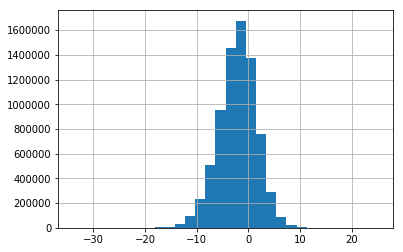

In [5]:
gdelt['AVG(AvgTone)'].hist(bins=30);
plt.xlabel("AvgTone");

We see that it is approximately normal, with a minor left skew.

# Data Preparation and Feature Engineering

As mentioned in the last section, the data has already been aggregated up to find means of our AvgTone and NumMentions columns. In this section we will explore the features of our dataset and consider various ways engineer them into more predictive features.

First, we look at NumMentions. We will find that this value has a large skew to it, with a majority of values being under 500.

In [ ]:
gdelt['AVG(NumMentions)'].hist(bins=30);
plt.xlabel("numMentions");

To help smooth this data, we will normalize it.

In [ ]:
example_samp['norm_NumMentions'] = (example_samp['AVG(NumMentions)'] - example_samp['AVG(NumMentions)'].mean())/ \
                                        example_samp['AVG(NumMentions)'].std()

In [ ]:
example_samp['norm_NumMentions'].hist();

Next, we explore the distribution of values in the country codes. To effectively visualize this, we first bin some of the rarer codes into their own label.

In [ ]:
unify_rare_cats(example_samp, "Actor1CountryCode", .0075)

In [ ]:
example_samp['Actor1CountryCode_unify'].cat.remove_unused_categories() \
                            .value_counts().plot(kind="bar");
plt.xlabel("Country")
plt.ylabel("Occurrence Count");

We see that there are quite a few records without a known country code and that there is a large concentration of occurrences in relatively small percentage of the data. This makes sense, as we would expect places with more of a media presence to generate more exhaustive media coverage of events. It does indicate that we should be careful and generalizing a model over the entire dataset, in case that some features which are unique to a country are not present in others.

We repeat this analysis for our other categorical columns regarding Actor1 as well as EventRootCode. This procedure can also be repeated for Actor2 columns.

In [ ]:
unify_rare_cats(example_samp, "Actor1Type1Code", .01)
unify_rare_cats(example_samp, "Actor1Geo_CountryCode", .01)

In [ ]:
# Actor1Type1Code, Actor1Geo_CountryCode, EventRootCode
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

plt.subplot(1, 3, 1)
example_samp['Actor1Type1Code_unify'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Type Code');
             
plt.subplot(1, 3, 2)
example_samp['Actor1Geo_CountryCode_unify'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Country');

plt.subplot(1, 3, 3)
example_samp['EventRootCode'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Event Root Code');

We see in the type codes there are quite a few unknowns. Additionally GOV occurs quite often. For Actor1Geo_CountryCode, we see that a lot of actions take place within the United States, but it still pares in comparison to the total amount of actions that occur in countries which appear more rarely. Finally for the EventCodes, our five most common verbs are "Consult", "Make Public Statement", "Engage in Diplomatic Cooperation", "Express Intent to Cooperate", and "Appeal".

So far, our investigation indicates that we have a lot of categorical columns with a lot of missing values. To handle them, we'll create dummy indicator values for each category which does come with the risk of a much higher dimension problem space. We'll also map any unknown values to the value "UNK" before training our models. 

There are some more sophisticated methods of dimensionality reduction we can try with our categories, like only preserving countries which have "enough" records, and mapping all others to "OTHER". We could also try a more sophisticated method of only preserving those countries which have a statistically significant and large AvgTone difference, as measured by taking the overall mean of all countries as the population mean, and measuring the deviance of a particular country from this mean. However, it turns out that neither of this methods do much to improve predictive accuracy, and so we do not discuss these any further in this report.

What we do build our models on is rather simple. We partition our dataset out by "Actor1CountryCode", so for example, we build individual models for "USA" and "GBR". This helps to isolate us from the noise and/or conflicting signals that may arise from different characteristics of countries when involved in some action upon Actor2. 

If we want further dimensionality reduction, we can also consider "Actor2CountryCode" as reduced to whether Actor1 is the same as Actor2. What this means is the country of the actors was the same, and in sense the event was "Internal". This distinction appears to capture a lot of the variance contributed by the "Actor2CountryCode" column, but we will achieve higher accuracy including the full range of values. We have a lot of data, and so the dimensionality increase can be compensated for, at the expense of additional compute time.

Finally, we will find that "Actor1Geo_CountryCode" and "Actor2Geo_CountryCode" appear to explain very little variance in the AvgTone, and so we will quickly omit those columns from our training. This will reduce some of the gain in dimensionality from including "Actor2CountryCode". 

# Model Exploration

We first build a relatively small sample of our data to try initial quick model constructions to get an idea of their accuracy. The init_sample function drops the "SQLDATE" column, normalizes "NumMentions" as "norm_NumMentions" and drops the "NumMentions" column, and cleans our categories to omit unused categories.

We distinguish between "naive" samples, which include all of the columns, and "pared" samples which omit the colums "Actor1Geo_CountryCode" and "Actor2Geo_CountryCode". In each set of samples, both naive and pared, we train models on the entire sample, the sample restricting "Actor1CountryCode" to "USA" and the sample restricting "Actor1CountryCode" and mapping "Actor2CountryCode" to the boolean of whether Actor1 is the same as Actor2.

In [31]:
test_samp = init_sample(gdelt, .05)
naive_samps = [("Naive Sample                               ", test_samp), 
               ("Naive, Actor1CC = USA, Actor2CC -> Internal", ICM_INT_sample(test_samp, 'USA')), 
               ("Naive, Actor1CC = USA, Actor2CC Normal     ", ICM_SPEC_sample(test_samp, 'USA'))]
pared_samps = [("Pared Sample                               ", test_samp), 
               ("Pared, Actor1CC = USA, Actor2CC -> Internal", ICM_INT_sample(test_samp, 'USA')), 
               ("Pared, Actor1CC = USA, Actor2CC Normal     ", ICM_SPEC_sample(test_samp, 'USA'))]

In [44]:
def eval_model(model, samps, naive):
    print("Sample Type                                ", "Train Set Acc     ", "Test Set Acc     ")
    for samp_name, samp in naive_samps:
        regr = clone(model)
        if naive:
            trs, tes, model, model_samp, _, _ = train_naive(samp, regr)
        else:
            trs, tes, model, model_samp, _, _ = train_pared(samp, regr)
        print(samp_name, "{:.{}f}           ".format(trs, 5), "{:.{}f}".format(tes, 5))    

In [45]:
eval_model(linear_model.LinearRegression(), naive_samps, True)

Sample Type                                 Train Set Acc      Test Set Acc     
Naive Sample                                0.28935            -3725595943.51249
Naive, Actor1CC = USA, Actor2CC -> Internal 0.28388            -2756773909464481792.00000
Naive, Actor1CC = USA, Actor2CC Normal      0.29809            -166159611733427617792.00000


In [35]:
print("Sample Type                                ", "Train Set Acc     ", "Test Set Acc     ")
for samp_name, samp in naive_samps:
    regr = Ridge()
    trs, tes, model, model_samp, _, _ = train_naive(samp, regr)
    print(samp_name, "{:.{}f}           ".format(trs, 5), "{:.{}f}".format(tes, 5))

Sample Type                                 Train Set Acc      Test Set Acc     
Naive Sample                                0.28933            0.28109
Naive, Actor1CC = USA, Actor2CC -> Internal 0.28292            0.24440
Naive, Actor1CC = USA, Actor2CC Normal      0.29632            0.24579


In [36]:
print("Sample Type                                ", "Train Set Acc     ", "Test Set Acc     ")
for samp_name, samp in naive_samps:
    regr = Ridge()
    trs, tes, model, model_samp, _, _ = train_pared(samp, regr)
    print(samp_name, "{:.{}f}           ".format(trs, 5), "{:.{}f}".format(tes, 5))

Sample Type                                 Train Set Acc      Test Set Acc     
Naive Sample                                0.28933            0.28109
Naive, Actor1CC = USA, Actor2CC -> Internal 0.28292            0.24440
Naive, Actor1CC = USA, Actor2CC Normal      0.29632            0.24579


In [6]:
good1, good1_samp = None, None
dt = None
for idx, samp in enumerate(naive_samps):
    dt = tree.DecisionTreeRegressor(max_depth=10)
    trs, tes, model, model_samp, _, _ = train_naive(samp, dt)
    print(idx, trs, tes)
    if idx == 3:
        good1, good1_samp = model, model_samp

0 0.19628313861021374 0.17333226567732452
1 0.24202593211236478 0.09858590555389501
2 0.24261801641111336 0.12471991794039627


In [7]:
good2, good2_samp = None, None
dt = None
for idx, samp in enumerate(pared_samps):
    dt = tree.DecisionTreeRegressor(max_depth=10)
    trs, tes, model, model_samp, _, _ = train_pared(samp, dt)
    print(idx, trs, tes)
    if idx == 1:
        good2, good2_samp = model, model_samp

0 0.19628313861021374 0.1714599469965984
1 0.24202593211236467 0.10263845201368149
2 0.24261801641111336 0.11067761063503523


In [8]:
good1, good1_samp = None, None
sv = svm.SVR()
for idx, samp in enumerate(naive_samps):
    sv = svm.SVR(max_iter=100, verbose=True)
    trs, tes, model, model_samp, _, _ = train_naive(samp, sv)
    print(idx, trs, tes)
    if idx == 3:
        good1, good1_samp = model, model_samp

[LibSVM]

C:\Users\e.istre91\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0 -0.454002971516422 -0.4223393579632764
[LibSVM]1 -0.44213988964612394 -0.5115034390914042
[LibSVM]2 -0.3823166895529788 -0.44419578495544143


In [9]:
good2, good2_samp = None, None
sv = svm.SVR()
for idx, samp in enumerate(pared_samps):
    sv = svm.SVR(max_iter=100, verbose=True)
    trs, tes, model, model_samp, _, _ = train_pared(samp, sv)
    print(idx, trs, tes)
    if idx == 1:
        good2, good2_samp = model, model_samp

[LibSVM]

C:\Users\e.istre91\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0 -0.454002971516422 -0.4223393579632764
[LibSVM]1 -0.44213988964612394 -0.5115034390914042
[LibSVM]2 -0.3823166895529788 -0.44419578495544143


In [10]:
good1, good1_samp = None, None
rfc = None
for idx, samp in enumerate(naive_samps):
    rfc = RandomForestRegressor(max_depth=7)
    trs, tes, model, model_samp, _, _ = train_naive(samp, rfc)
    print(idx, trs, tes)
    if idx == 3:
        good1, good1_samp = model, model_samp

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0 0.1655744505235709 0.16198411512635835


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


1 0.21574198239401157 0.1468327130307373
2 0.20140454001248886 0.13759870508931737


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [11]:
good2, good2_samp = None, None
rfc = None
for idx, samp in enumerate(pared_samps):
    rfc = RandomForestRegressor(max_depth=7)
    trs, tes, model, model_samp, _, _ = train_pared(samp, rfc)
    print(idx, trs, tes)
    if idx == 1:
        good2, good2_samp = model, model_samp

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


0 0.16053020778765137 0.15710196510214047


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


1 0.20581983798824355 0.13761248176145313
2 0.22066372691273872 0.14977551370050413


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [17]:
good1, good1_samp = None, None
gbr = None
for idx, samp in enumerate(naive_samps):
    gbr = GradientBoostingRegressor()
    start_time = time.time()
    trs, tes, model, model_samp, _, _ = train_naive(samp, gbr)
    print(idx, trs, tes, time.time() - start_time)

0 0.23693303395193144 0.2307851373215999 56.33863711357117
1 0.29205056078009284 0.18654139472884368 2.336773633956909
2 0.29598994599450845 0.1983531069384752 2.7521584033966064


In [19]:
good2, good2_samp = None, None
gbr = None
for idx, samp in enumerate(pared_samps):
    gbr = GradientBoostingRegressor()
    start_time = time.time()
    trs, tes, model, model_samp, _, _ = train_pared(samp, gbr)
    print(idx, trs, tes, time.time() - start_time)

0 0.23693303395193144 0.23064582472679152 54.702860832214355
1 0.29205056078009284 0.18614356662086418 1.967256784439087
2 0.29598994599450845 0.19967377650362672 2.687342643737793


In [14]:
countries = list(test_samp['Actor1CountryCode'].value_counts().index)
small_list = countries[:5]
ICM_INT_samps = []
ICM_SPEC_samps = []

for country in small_list:
    ICM_INT_samps.append(ICM_INT_sample(test_samp, country))
    ICM_SPEC_samps.append(ICM_SPEC_sample(test_samp, country))

Interpretable Results

Future Work

How to Use